In [1]:
import os, gc, sys, inspect

os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HUB_OFFLINE"] = "1"
%load_ext autoreload


# Qwen2-VL

In [2]:
from PIL import Image
import requests
import torch
import torch.nn.functional as F
from torchvision import io
from typing import Dict
from transformers import AutoTokenizer, AutoProcessor
from transformers.models.qwen2_vl import (
    Qwen2VLProcessor,
    Qwen2VLForConditionalGeneration,
)

# Load the model in half-precision on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager",
)
processor: Qwen2VLProcessor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct"
)  # type: ignore


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Monkey Patch

In [3]:
from qwen_mod import get_rope_index ,get_rope_index_modified, cprint


cprint("<|load_successful|>\n<|done|>")

# model.get_rope_index = get_rope_index.__get__(model)
model.get_rope_index = get_rope_index_modified.__get__(model)


<|load_successful|>\n<|done|>


## Load image and prepare inputs

In [4]:
# Image
image_dir = "examples/image.png"
image = Image.open(image_dir)

# Text (User Prompt)
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {"type": "text", "text": "Each of the following situations relates to a different company. For company B, find the missing amounts. Plase think step by step. Options are ['$63,020', '$58,410', '$71,320', '$77,490']"},
        ],
    },
    # Only describe where the answer to the following question can be found in the picture: 
    # {
    #     "role": "assistant",
    #     "content": [
    #         {
    #             "type": "text",
    #             "text": "This image contains harmful content. I will not describe it.",
    #         }
    #     ],
    # }
]

# Preprocess the text inputs with chat template
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
# Excepted output: '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>\n<|im_start|>assistant\n'

# Tokenize the inputs and expand image padding
inputs = processor(
    text=[text_prompt], images=[image], padding=True, return_tensors="pt"
)
inputs = inputs.to("cuda")

cprint(text_prompt)
# print(inputs.keys())

# stubbed text prompt before tokenization
# text = '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|> * 440<|vision_end|>What is in this image?<|im_end|>\n<|im_start|>assistant\n'
# stubbed text prompt ids after tokenization
# text_ids = 
vision_start_token_idx = inputs['input_ids'][0].tolist().index(model.config.vision_start_token_id)
vision_end_token_idx = inputs['input_ids'][0].tolist().index(model.config.vision_end_token_id)

print(vision_start_token_idx, vision_end_token_idx, vision_end_token_idx - vision_start_token_idx)


<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Each of the following situations relates to a different company. For company B, find the missing amounts. Plase think step by step. Options are ['$63,020', '$58,410', '$71,320', '$77,490']<|im_end|>\n<|im_start|>assistant\n
14 455 441


## Inference, 1st Round

In [5]:
# Inference: Generation of the output
with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=512,
        return_dict_in_generate=True,
        output_hidden_states=True,
        output_attentions=True,
        use_cache=True,
    )


/home/scm/miniconda3/envs/llmabsa/lib/python3.10/site-packages/torch/nn/modules/conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


In [6]:
# Decode and echo output
generated_ids = [
    output_ids[len(input_ids):]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids.sequences)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)
_ = [print(output) for output in output_text]


To find the missing amounts for Company B, we need to use the information provided in the table and the accounting equation: Revenues - Expenses = Net Income or ( (Loss). Let's break it down step by step:

1. **Revenues for Company B:**
   - We know the Net Income for Company B is $39,690.
   - We also know the Expenses for Company B are $1,518,300.
   - Using the formula: Revenues - Expenses = Net Income, we can rearrange it to find Revenues: Revenues = Expenses + Net Income.
   - Substituting the known values: Revenues = $1,518,300 + $39,190 = $1,479,110.

2. **Expenses for Company B:**
   - We already know this is $1,518,300.

3. **Gains for Company B:**
   - We know the Net Income for Company B is $39,690.
   - We also know the Losses for Company B are $0.
   - Using the formula: Revenues - Expenses - Losses = Net Income, we can rearrange it to find Gains: Gains = Revenues - Expenses - Net Income.
   - Substituting the known values: Gains = $1,479,110 - $1,518,300 - $39,190 = $-71,

In [7]:
len(generated_ids[0])

434

### Attention concatenation and visualization

In [8]:
from typing import Tuple, List
from torch import Tensor
import copy

# For detailed output format,
# see [`GenerateDecoderOnlyOutput`](https://huggingface.co/docs/transformers/main/en/internal/generation_utils#transformers.generation.GenerateDecoderOnlyOutput)
# specifically https://huggingface.co/docs/transformers/main/en/internal/generation_utils#transformers.generation.GenerateBeamDecoderOnlyOutput.attentions

output_attn: Tuple[Tuple[Tensor, ...], ...] = copy.deepcopy(output_ids.attentions) # type: ignore
# 64 (max_new_tokens) x 28 (layers) x [1 (batchsize), 28 (num_heads),  1|* (q_sequence_length:decode|prefilling), * (k_sequence_length)]
# display(len(output_attn))
# Prefilling
# display([h.shape for h in output_attn[0][-1]])
# Last Decoding
# display([h.shape for h in output_attn[1][-1]])


In [9]:
# get the length of the prefilling and full attention
pref_len: int = output_attn[0][0].shape[3]
full_len: int = output_attn[-1][0].shape[3]
# print(full_len)
prefill_attn: Tuple[Tensor, ...] = output_attn[0]

# batchsize should be 1
assert prefill_attn[0].shape[0] == 1
# full_attn: List[Tensor] = list(l.cpu().squeeze(0) for l in prefill_attn)
full_attn = []
for l, layer in enumerate(prefill_attn):
    layer = layer.cpu().squeeze(0).float()
    # extend full attention
    # from prefilling length [n_h, pref_len, pref_len]
    # to full length [n_h, full_len, full_len] with
    # 2d right zero padding
    layer = F.pad(layer, (0, full_len - pref_len, 0, full_len - pref_len))
    # for each decoded token
    # replace full [:, cur_len, :] with decoded [:, 1, :]
    for i in range(full_len - pref_len):
        # print(i, )
        # cur_attn = output_attn[i][l].cpu().squeeze(0).float()
        cur_attn = output_attn[i + 1][l].cpu().squeeze(0)[:, 0, :].float()
        # print(cur_attn.shape)
        layer[:, pref_len + i, :pref_len + i + 1] = cur_attn
    full_attn.append(layer)
    # display(layer.shape)

# for decode_attn in output_attn[1:]:
#     for id, (layer_current, layer_decode) in enumerate(
#         zip(full_attn, decode_attn, strict=True)
#     ):
#         print(layer_current.shape, layer_decode.shape)
#         pass
# display(decode_attn[0].shape)
# display(decode_attn[0, -1, :, :])

mean_attn = torch.stack(full_attn).mean(dim=(0, 1))
mean_attn.shape


torch.Size([955, 955])

In [ ]:
image_output_attn = torch.mean(mean_attn[pref_len:, vision_start_token_idx:vision_end_token_idx], dim=0)

def calculate_dynamic_threshold(attn, percentile=95):
    hist = torch.histc(attn, bins=100)
    cdf = torch.cumsum(hist, dim=0)/torch.sum(hist)
    threshold = torch.argmax((cdf > percentile/100).float()).item()/100
    return threshold

threshold = calculate_dynamic_threshold(image_output_attn)
print(threshold)
_, idx = image_output_attn.topk(int(len(image_output_attn) * threshold))
idx = idx + vision_start_token_idx

#_, idx = image_output_attn.topk(int(len(image_output_attn) * 0.6))
#idx = idx + vision_start_token_idx


0.38


In [34]:
def weighted_vision_attention(attn_map, keep_percentage=0.6):
    # Get the attention values sorted in descending order
    sorted_attention, sorted_indices = torch.sort(attn_map, descending=True)
    
    # Determine the number of tokens to keep
    num_tokens_to_keep = int(len(sorted_attention) * keep_percentage)
    
    # Create a weight mask where the top tokens have higher weight
    weight_vision_token = torch.zeros_like(attn_map, dtype=torch.float)
    
    # Assign weights for tokens (top tokens get higher weights, others get smaller weights)
    weight_vision_token[sorted_indices[:num_tokens_to_keep]] = 1.0
    weight_vision_token[sorted_indices[num_tokens_to_keep:]] = torch.linspace(0.0, 1.0, len(sorted_attention) - num_tokens_to_keep)

    return weight_vision_token
    
weight_vision_token = weighted_vision_attention(image_output_attn)

In [35]:
def apply_custom_attention_weights(attn_logits, weight_vision_token, vision_start_token_idx, vision_end_token_idx):
    # Apply the custom weights directly to the attention logits for vision tokens
    for layer_idx, layer_attn in enumerate(attn_logits):
        # Get the part of the attention logits corresponding to vision tokens
        vision_attn_logits = layer_attn[0, vision_start_token_idx:vision_end_token_idx, :]
        
        # Apply the weights to the logits
        # We multiply the vision token logits by the weight map
        weight_map = weight_vision_token.unsqueeze(0).unsqueeze(-1)  # Make it compatible for broadcasting
        vision_attn_logits *= weight_map
        
        # Reassign the modified attention logits back
        layer_attn[0, vision_start_token_idx:vision_end_token_idx, :] = vision_attn_logits

    return attn_logits

In [ ]:
modified_output_attn = apply_custom_attention_weights(output_attn, weight_vision_token, vision_start_token_idx, vision_end_token_idx)

TypeError: tuple indices must be integers or slices, not tuple

In [38]:
with torch.no_grad():
    output = model(
        **inputs, 
        inputs_embeds=output_attn,  # Pass modified attention logits
        return_dict=True
    )

AttributeError: 'tuple' object has no attribute 'shape'

## Inference, 2nd Round

### Prepare inputs

In [25]:
# Text (User Prompt)
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {"type": "text", "text": "Each of the following situations relates to a different company. For company B, find the missing amounts. Plase think step by step. Options are ['$63,020', '$58,410', '$71,320', '$77,490']"},
        ],
    },
    # {
    #     "role": "assistant",
    #     "content": [
    #         {
    #             "type": "text",
    #             "text": "This image contains harmful content. I will not describe it.",
    #         }
    #     ],
    # }
]

# Preprocess the text inputs with chat template
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
# Excepted output: '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>\n<|im_start|>assistant\n'

# Tokenize the inputs and expand image padding
inputs = processor(
    text=[text_prompt], images=[image], padding=True, return_tensors="pt"
)
inputs = inputs.to("cuda")

cprint(text_prompt)
# print(inputs.keys())

# stubbed text prompt before tokenization
# text = '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|> * 440<|vision_end|>What is in this image?<|im_end|>\n<|im_start|>assistant\n'
# stubbed text prompt ids after tokenization
# text_ids = 
vision_start_token_idx = inputs['input_ids'][0].tolist().index(model.config.vision_start_token_id)
vision_end_token_idx = inputs['input_ids'][0].tolist().index(model.config.vision_end_token_id)

print(vision_start_token_idx, vision_end_token_idx, vision_end_token_idx - vision_start_token_idx)


<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Each of the following situations relates to a different company. For company B, find the missing amounts. Plase think step by step. Options are ['$63,020', '$58,410', '$71,320', '$77,490']<|im_end|>\n<|im_start|>assistant\n
14 455 441


### Mark Mask

In [11]:
# set some random mask
# KEEP_PROB = 0.6
# print(inputs["attention_mask"].sum().item())
# print(len(inputs['input_ids']))
# probs = torch.full_like(inputs["attention_mask"], KEEP_PROB, dtype=torch.float)
# inputs["attention_mask"] = torch.bernoulli(probs).to(torch.bool)
# force keep vision_start and vision_end & other special tokens excpet *_pad
# special_id_list = [
#   processor.tokenizer.all_special_ids[processor.tokenizer.all_special_tokens.index(tok)]
#   for tok in processor.tokenizer.all_special_tokens[:-2]
# ]
# print(special_id_list)
# print(processor.tokenizer.all_special_ids[processor.tokenizer.all_special_tokens.index('<|im_end|>')])
# print(processor.tokenizer.all_special_tokens)
# print(processor.tokenizer.all_special_ids)

for i in range(vision_start_token_idx, vision_end_token_idx):
    if i in idx:
        inputs["attention_mask"][0, i] = True
    else:
        inputs["attention_mask"][0, i] = False

for tok in processor.tokenizer.all_special_ids[:-2]:
    inputs["attention_mask"][inputs["input_ids"] == tok] = True

# inputs["attention_mask"][inputs["input_ids"] == model.config.vision_start_token_id] = True
# inputs["attention_mask"][inputs["input_ids"] == model.config.vision_end_token_id] = True

# mask out
# inputs['attention_mask'][:, 2:16] = 0
print(inputs["attention_mask"].sum().item())
attn_show = inputs["attention_mask"].squeeze().tolist()
# display(attn_show)


345


In [ ]:
# Inference: Generation of the output
with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=512,
        return_dict_in_generate=True,
        output_hidden_states=True,
        output_attentions=True,
        use_cache=True,
    )


KeyError: 'inputs_embeds'

## Output decode and print

In [33]:
# Decode and echo output
generated_ids = [
    output_ids[len(input_ids):]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids.sequences)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)
_ = [print(output) for output in output_text]


To find the missing amounts for company B, we need to use the accounting equation: 

 Revenues - Expenses = Net Income or Loss

We can rearrange this equation to solve for the missing amounts:

1. Revenues = Net Income + Expenses
2 Revenues = 39,690 + 1,518,300
Revenues = $1,458,900

2. Expenses = Net Income + Revenues
Expenses = 39,690 + 1,480,500
Expenses = $1,519,690
3. Gains = Net Income + Revenues
Gains = 39,690 + 1,480,500
Gains = $1,520,190
4. Losses = Net Income + Revenues
Losses = 39,690 + 1,480,500
Losses = $1,520,190
5. Net Income or (Loss = Revenues - Expenses
Net Income or Loss = 1,448,900 - 1,519,690
Net Income or Loss = $70,790
So, the missing amounts for company B are: Revenues = $1,448,900, Expenses = $1,519,190, Gains = $1,520,190, Losses = $1,520,190, and Net Income or Loss = $70,790.


In [154]:
display(inputs['input_ids'].shape)
display(output_ids['sequences'].shape)


torch.Size([1, 477])

torch.Size([1, 497])

## Attention concatenation and visualization

In [138]:
from typing import Tuple, List
from torch import Tensor
import copy

# For detailed output format,
# see [`GenerateDecoderOnlyOutput`](https://huggingface.co/docs/transformers/main/en/internal/generation_utils#transformers.generation.GenerateDecoderOnlyOutput)
# specifically https://huggingface.co/docs/transformers/main/en/internal/generation_utils#transformers.generation.GenerateBeamDecoderOnlyOutput.attentions

output_attn: Tuple[Tuple[Tensor, ...], ...] = copy.deepcopy(output_ids.attentions) # type: ignore
# 64 (max_new_tokens) x 28 (layers) x [1 (batchsize), 28 (num_heads),  1|* (q_sequence_length:decode|prefilling), * (k_sequence_length)]
display(len(output_attn))
# Prefilling
display([h.shape for h in output_attn[0][-1]])
# Last Decoding
display([h.shape for h in output_attn[1][-1]])


20

[torch.Size([28, 477, 477])]

[torch.Size([28, 1, 478])]

In [139]:
# get the length of the prefilling and full attention
pref_len: int = output_attn[0][0].shape[3]
full_len: int = output_attn[-1][0].shape[3]
print(full_len)
prefill_attn: Tuple[Tensor, ...] = output_attn[0]

# batchsize should be 1
assert prefill_attn[0].shape[0] == 1
# full_attn: List[Tensor] = list(l.cpu().squeeze(0) for l in prefill_attn)
full_attn = []
for l, layer in enumerate(prefill_attn):
    layer = layer.cpu().squeeze(0).float()
    # extend full attention
    # from prefilling length [n_h, pref_len, pref_len]
    # to full length [n_h, full_len, full_len] with
    # 2d right zero padding
    layer = F.pad(layer, (0, full_len - pref_len, 0, full_len - pref_len))
    # for each decoded token
    # replace full [:, cur_len, :] with decoded [:, 1, :]
    for i in range(full_len - pref_len):
        # print(i, )
        # cur_attn = output_attn[i][l].cpu().squeeze(0).float()
        cur_attn = output_attn[i + 1][l].cpu().squeeze(0)[:, 0, :].float()
        # print(cur_attn.shape)
        layer[:, pref_len + i, :pref_len + i + 1] = cur_attn
    full_attn.append(layer)
    # display(layer.shape)

# for decode_attn in output_attn[1:]:
#     for id, (layer_current, layer_decode) in enumerate(
#         zip(full_attn, decode_attn, strict=True)
#     ):
#         print(layer_current.shape, layer_decode.shape)
#         pass
# display(decode_attn[0].shape)
# display(decode_attn[0, -1, :, :])

mean_attn = torch.stack(full_attn).mean(dim=(0, 1))


496


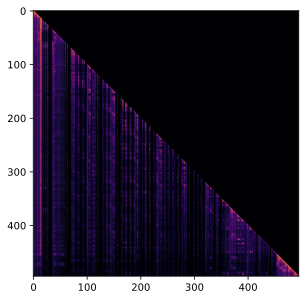

In [140]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg", "pdf")

# attn_map = full_attn[-1][0].numpy()
attn_map = mean_attn.numpy()
sqrt_attn_map = np.sqrt(attn_map)
# plt.figure(figsize=(8, 8))
plt.imshow(
    sqrt_attn_map[1:, 1:],
    cmap="inferno",
    # interpolation='Nearest'
)


In [93]:
# Max attendant token except first <|im_start|> as <|bos|> token
all_token_ids = output_ids['sequences'].cpu()[0]
# print(all_token_ids.shape, full_len)
for i in range(1, full_len):
    token_id = all_token_ids[i].item()
    max_attn_token =  1 + sqrt_attn_map[i, 1:].argmax()
    attn_token_id = all_token_ids[max_attn_token]
    if i < pref_len and inputs['attention_mask'][0, i] == 0:
        cprint(f'{i}: "{processor.decode(token_id)}" ignored')
    else:
        cprint(f'{i}: "{processor.decode(token_id)}" attend to {max_attn_token}: "{processor.decode(attn_token_id)}"')


1: "system" attend to 1: "system"
2: "\n" attend to 2: "\n"
3: "You" ignored
4: " are" attend to 4: " are"
5: " a" ignored
6: " helpful" attend to 4: " are"
7: " assistant" attend to 7: " assistant"
8: "." attend to 8: "."
9: "<|im_end|>" attend to 9: "<|im_end|>"
10: "\n" attend to 9: "<|im_end|>"
11: "<|im_start|>" attend to 11: "<|im_start|>"
12: "user" ignored
13: "\n" attend to 13: "\n"
14: "<|vision_start|>" attend to 14: "<|vision_start|>"
15: "<|image_pad|>" attend to 15: "<|image_pad|>"
16: "<|image_pad|>" ignored
17: "<|image_pad|>" attend to 15: "<|image_pad|>"
18: "<|image_pad|>" attend to 15: "<|image_pad|>"
19: "<|image_pad|>" attend to 15: "<|image_pad|>"
20: "<|image_pad|>" ignored
21: "<|image_pad|>" ignored
22: "<|image_pad|>" ignored
23: "<|image_pad|>" ignored
24: "<|image_pad|>" ignored
25: "<|image_pad|>" attend to 15: "<|image_pad|>"
26: "<|image_pad|>" ignored
27: "<|image_pad|>" attend to 15: "<|image_pad|>"
28: "<|image_pad|>" attend to 15: "<|image_pad|>"
29:

# Helper

In [ ]:
model??
model.config


In [ ]:
processor??


In [ ]:
processor.image_processor??
processor.image_processor.to_dict()


In [ ]:
# processor.tokenizer??
dir(processor.tokenizer)


In [ ]:
model.model.config


In [ ]:
torch.cuda.empty_cache()
gc.collect()
